In [38]:
import numpy as np
import scipy.stats as st
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from sklearn.linear_model import BayesianRidge
from sklearn.model_selection import train_test_split

In [39]:
def get_polynomial_design_matrix(x, degree):
    """
    Returns the polynomial design matrix of ``degree`` evaluated at ``x``.
    """
    # Make sure this is a 2D numpy array with only one column
    x = x[:,None]
    assert isinstance(x, np.ndarray), 'x is not a numpy array.'
    assert x.ndim == 2, 'You must make x a 2D array.'
    assert x.shape[1] == 1, 'x must be a column.'
    # Start with an empty list where we are going to put the columns of the matrix
    cols = []
    # Loop over columns and add the polynomial
    for i in range(degree+1):
        cols.append(x ** i)
    return np.hstack(cols)

In [40]:
def get_rbf_design_matrix(x, x_centers, ell):
    # Make sure this is a 2D numpy array with only one column
    assert isinstance(x, np.ndarray), 'x is not a numpy array.'
    assert x.ndim == 2, 'You must make x a 2D array.'
    assert x.shape[1] == 1, 'x must be a column.'
    N = x.shape[0]
    cols = [np.ones((N, 1))]
    # Loop over columns and add the polynomial
    for i in range(x_centers.shape[0]):
        cols.append(np.exp(-(x - x_centers[i]) ** 2 / ell))
    return np.hstack(cols)

In [41]:
def get_fourier_design_matrix(x, L, num_terms):
    """
    Fourier expansion with ``num_terms`` cosines and sines.
    """
    # Make sure this is a 2D numpy array with only one column
    assert isinstance(x, np.ndarray), 'x is not a numpy array.'
    assert x.ndim == 2, 'You must make x a 2D array.'
    assert x.shape[1] == 1, 'x must be a column.'
    N = x.shape[0]
    cols = [np.ones((N, 1))]
    # Loop over columns and add the polynomial
    for i in range(1, int(num_terms / 2)):
        cols.append(np.cos(2 * i * np.pi / L * x))
        cols.append(np.sin(2 * i * np.pi / L * x))
    return np.hstack(cols)


In [42]:
def sigmoid(x, L, x0, k, b):
    y = L / (1 + np.exp(-k*(x-x0)))+b
    return (y)

In [43]:
# Sample Polynomial Training Data
x = np.linspace(0,4*np.pi,1000)

# Sample Polynomial Training Data
#y = np.random.normal(x**2, 0.5)

# Sample Fourier Training Data
#y = np.random.normal(np.cos(x), .5)

# Sample Sigmoid Training Data
L_sample  = 10
x0_sample = np.median(x)
k_sample  = 1
b_sample  = 2
y = np.random.normal(sigmoid(x, L_sample, x0_sample, k_sample, b_sample), 0.5)

In [44]:
######################
# Input real data here
######################

In [45]:
# Split data into training & validation data
x_train, x_valid, y_train, y_valid = train_test_split(x, y, test_size=.6)

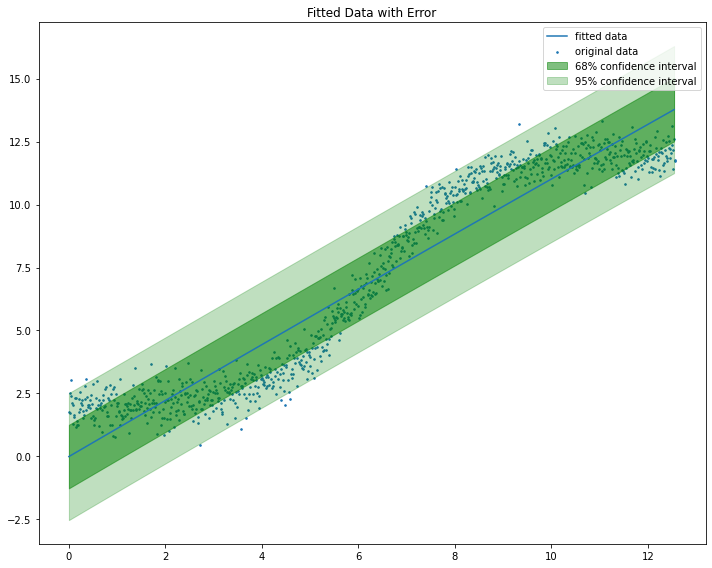

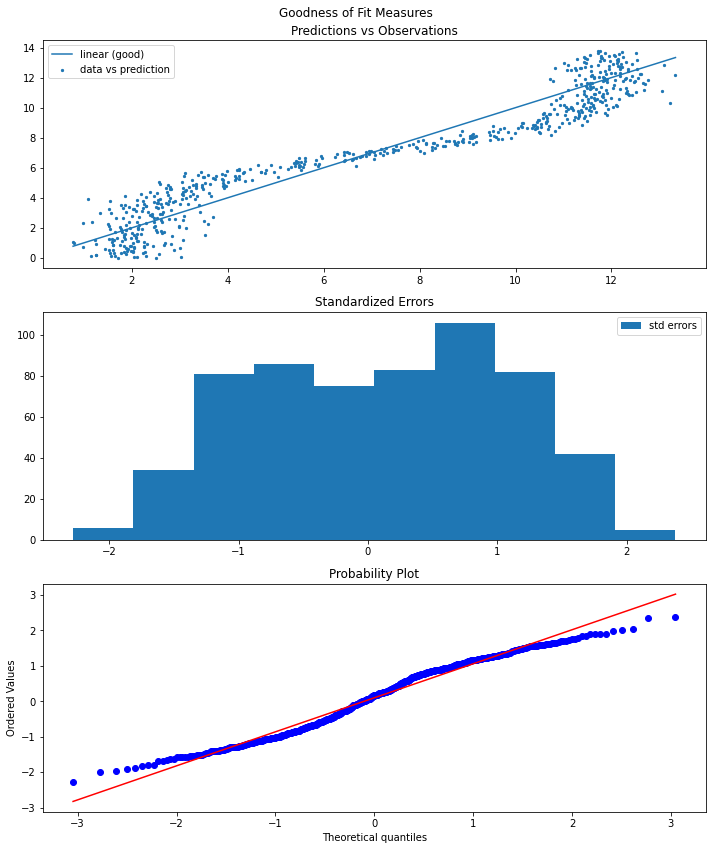

In [46]:
#############################################
############## POLYNOMIAL FIT ##############
#############################################

degree = 2

#####################
## MODEL GENERATION##
#####################

# Creating the Design Matrix and Model
Phi_train = get_polynomial_design_matrix(x_train, degree)
model = BayesianRidge(normalize=True, fit_intercept=False).fit(Phi_train,y_train)

# Creating Visualization Data for Model
xx = np.linspace(min(x_train), max(x_train),1000)
Phi_xx = get_polynomial_design_matrix(xx, degree)
yy, std_dev = model.predict(Phi_xx, return_std=True,)
yy_plus   = yy + std_dev
yy_2plus  = yy + 2*std_dev
yy_minus  = yy - std_dev
yy_2minus = yy - 2*std_dev

# Create a Figure
fig = plt.figure(figsize=(10,8))
ax = plt.subplot2grid((1,1),(0,0))
ax.scatter(x, y, s=10, marker='.', label='original data')
ax.plot(xx, yy, label='fitted data')
ax.fill_between(xx, yy_plus, yy_minus, color='green', alpha=.5, label='68% confidence interval')
ax.fill_between(xx, yy_2plus, yy_2minus, color='green', alpha=.25, label='95% confidence interval')
ax.set_title('Fitted Data with Error')
ax.legend(loc='best');
fig.tight_layout()

#####################
## MODEL VALIDATION##
#####################

# Creating Validation Data
Phi_valid = get_polynomial_design_matrix(x_valid, degree)
yy_valid, yy_std = model.predict(Phi_valid, return_std=True)

# Create a Figure
fig = plt.figure(figsize=(10,12))
ax1 = plt.subplot2grid((3,1),(0,0))
ax2 = plt.subplot2grid((3,1),(1,0))
ax3 = plt.subplot2grid((3,1),(2,0))
fig.suptitle('Goodness of Fit Measures')

# Observations vs Predictions
line = np.linspace(min(y_valid), max(y_valid), 100)
ax1.plot(line, line, label = 'linear (good)')
ax1.scatter(y_valid, yy_valid, label='data vs prediction', s=5)
ax1.set_title('Predictions vs Observations')
ax1.legend(loc='best')

# Standardized Errors
std_errors = (y_valid - yy_valid)/yy_std
ax2.hist(std_errors, label='std errors')
ax2.set_title('Standardized Errors')
ax2.legend(loc='best')

# Quantile-Quantile Plot
st.probplot(std_errors, dist=st.norm, plot=ax3)


fig.tight_layout()

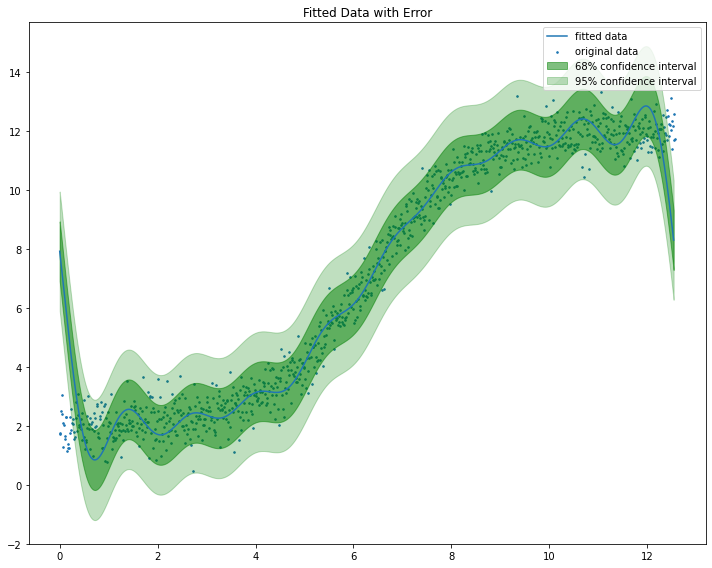

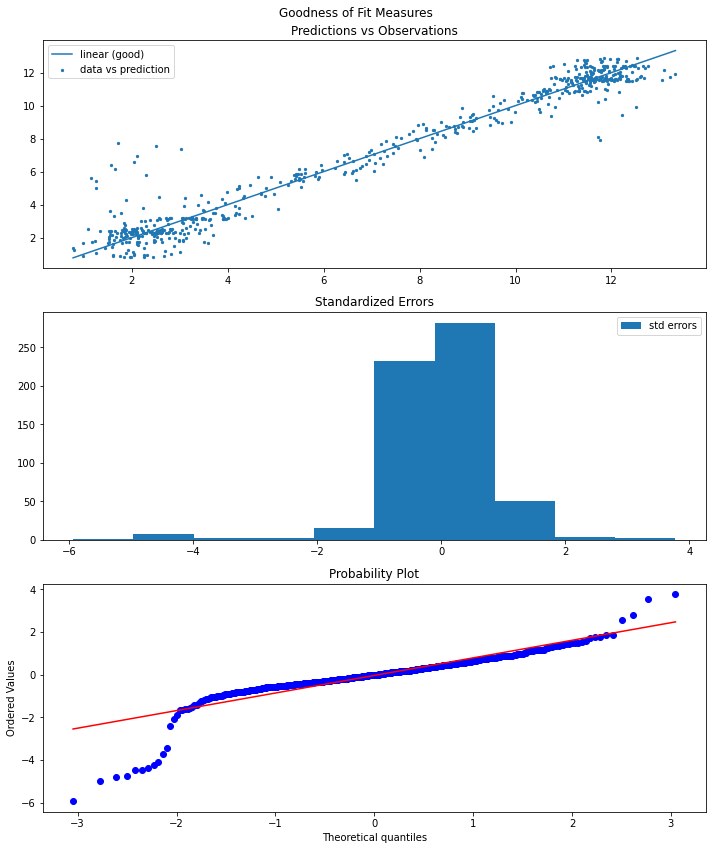

In [47]:
#############################################
################ FOURIER FIT ################
#############################################

l_scale = max(x)
num_terms = 20

#####################
## MODEL GENERATION##
#####################

# Creating the Design Matrix and Model
Phi_train = get_fourier_design_matrix(x_train[:,None], l_scale, num_terms)
model = BayesianRidge(normalize=True, fit_intercept=False).fit(Phi_train,y_train)

# Creating Visualization Data for Model
xx = np.linspace(min(x_train), max(x_train),1000)
Phi_xx = get_fourier_design_matrix(xx[:,None], l_scale, num_terms)
yy, std_dev = model.predict(Phi_xx, return_std=True)
yy_plus   = yy + std_dev
yy_2plus  = yy + 2*std_dev
yy_minus  = yy - std_dev
yy_2minus = yy - 2*std_dev

# Create a Figure
fig = plt.figure(figsize=(10,8))
ax = plt.subplot2grid((1,1),(0,0))
ax.scatter(x, y, s=10, marker='.', label='original data')
ax.plot(xx, yy, label='fitted data')
ax.fill_between(xx, yy_plus, yy_minus, color='green', alpha=.5, label='68% confidence interval')
ax.fill_between(xx, yy_2plus, yy_2minus, color='green', alpha=.25, label='95% confidence interval')
ax.set_title('Fitted Data with Error')
ax.legend(loc='best');
fig.tight_layout()

#####################
## MODEL VALIDATION##
#####################

# Creating Validation Data
Phi_valid = get_fourier_design_matrix(x_valid[:,None], l_scale, num_terms)
yy_valid, yy_std = model.predict(Phi_valid, return_std=True)

# Create a Figure
fig = plt.figure(figsize=(10,12))
ax1 = plt.subplot2grid((3,1),(0,0))
ax2 = plt.subplot2grid((3,1),(1,0))
ax3 = plt.subplot2grid((3,1),(2,0))
fig.suptitle('Goodness of Fit Measures')

# Observations vs Predictions
line = np.linspace(min(y_valid), max(y_valid), 100)
ax1.plot(line, line, label = 'linear (good)')
ax1.scatter(y_valid, yy_valid, label='data vs prediction', s=5)
ax1.set_title('Predictions vs Observations')
ax1.legend(loc='best')

# Standardized Errors
std_errors = (y_valid - yy_valid)/yy_std
ax2.hist(std_errors, label='std errors')
ax2.set_title('Standardized Errors')
ax2.legend(loc='best')

# Quantile-Quantile Plot
st.probplot(std_errors, dist=st.norm, plot=ax3)


fig.tight_layout()

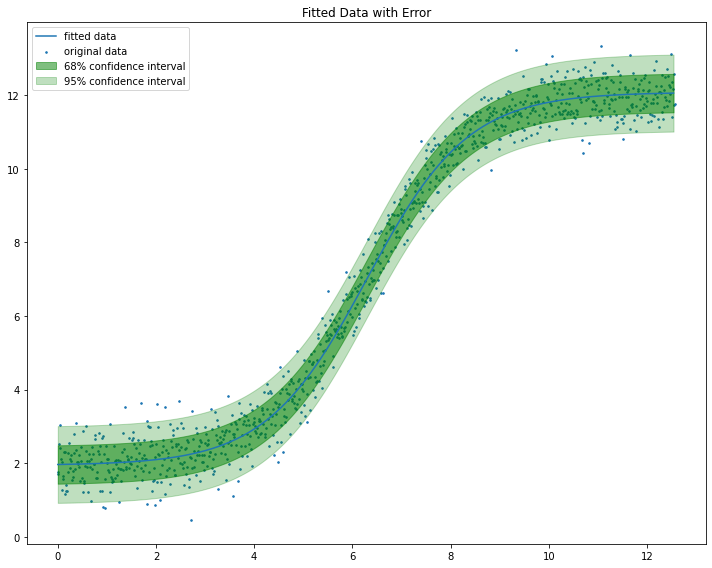

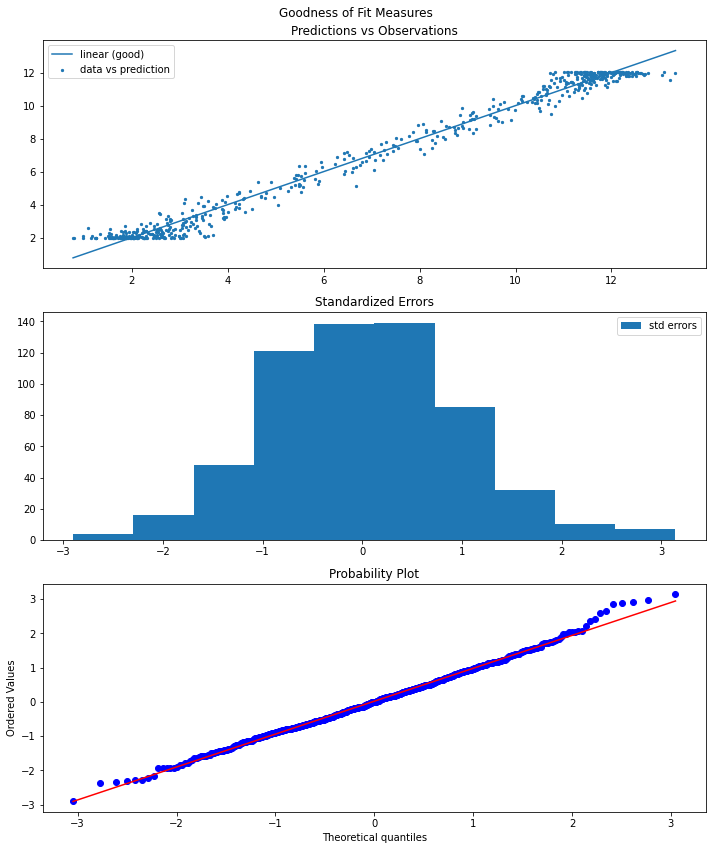

In [48]:
#############################################
################ SIGMOID FIT ################
#############################################



############################
##    INITIAL GUESS +     ##
## PARAMETER OPTIMIZATION ##
############################

# Initial Guess
L  = 10
x0 = np.median(x_train)
k  = 1
b  = 2
p0 = [1, np.median(x_train), 1, 0]

# Fitting the Curve & Optimizing Parameters
popt, pcov = curve_fit(sigmoid, x_train, y_train, p0, method='dogbox')
L  = popt[0]
k  = popt[1]
x0 = popt[2]
b  = popt[3]

#####################
## MODEL GENERATION##
#####################

# Creating the Design Matrix and Model
Phi_train = sigmoid(x_train[:,None], L, k, x0, b)
model = BayesianRidge(normalize=True, fit_intercept=False).fit(Phi_train,y_train)

# Creating Visualization Data for Model
xx = np.linspace(min(x_train), max(x_train),1000)
Phi_xx = sigmoid(xx[:,None], L, k, x0, b)
yy, std_dev = model.predict(Phi_xx, return_std=True)
yy_plus   = yy + std_dev
yy_2plus  = yy + 2*std_dev
yy_minus  = yy - std_dev
yy_2minus = yy - 2*std_dev

# Create a Figure
fig = plt.figure(figsize=(10,8))
ax = plt.subplot2grid((1,1),(0,0))
ax.scatter(x, y, s=10, marker='.', label='original data')
ax.plot(xx, yy, label='fitted data')
ax.fill_between(xx, yy_plus, yy_minus, color='green', alpha=.5, label='68% confidence interval')
ax.fill_between(xx, yy_2plus, yy_2minus, color='green', alpha=.25, label='95% confidence interval')
ax.set_title('Fitted Data with Error')
ax.legend(loc='best');
fig.tight_layout()

#####################
## MODEL VALIDATION##
#####################

# Creating Validation Data
Phi_valid = sigmoid(x_valid[:,None], L, k, x0, b)
yy_valid, yy_std = model.predict(Phi_valid, return_std=True)

# Create a Figure
fig = plt.figure(figsize=(10,12))
ax1 = plt.subplot2grid((3,1),(0,0))
ax2 = plt.subplot2grid((3,1),(1,0))
ax3 = plt.subplot2grid((3,1),(2,0))
fig.suptitle('Goodness of Fit Measures')

# Observations vs Predictions
line = np.linspace(min(y_valid), max(y_valid), 100)
ax1.plot(line, line, label = 'linear (good)')
ax1.scatter(y_valid, yy_valid, label='data vs prediction', s=5)
ax1.set_title('Predictions vs Observations')
ax1.legend(loc='best')

# Standardized Errors
std_errors = (y_valid - yy_valid)/yy_std
ax2.hist(std_errors, label='std errors')
ax2.set_title('Standardized Errors')
ax2.legend(loc='best')

# Quantile-Quantile Plot
st.probplot(std_errors, dist=st.norm, plot=ax3)


fig.tight_layout()